<a href="https://colab.research.google.com/github/VvS-2403/smart-obesity-predictor/blob/main/Ensemble_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

Data processing: Replacing text labels with codes

**Adding the bmi feature**

In [ ]:
df = pd.read_csv("dataset.csv")
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})
binary_cols = ["family_history_with_overweight", "FAVC", "SCC", "SMOKE"]
df[binary_cols] = df[binary_cols].replace({"yes": 1, "no": 0})
df["BMI"] = df["Weight"] / (df["Height"] ** 2)
#id is irrelevant for classification
X = df.drop(["NObeyesdad", "id"], axis=1)
y = df["NObeyesdad"]

columns_to_scale = ["BMI","Height","Weight","CH2O", "FAF", "TUE", "FCVC", "NCP", "Age"]
columns_to_encode = ["CAEC", "CALC", "MTRANS"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[columns_to_scale])
X_scaled_df = pd.DataFrame(X_scaled, columns=columns_to_scale)

columns_to_encode = ["CAEC", "CALC", "MTRANS"]
mapping = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3,
    'Walking': 0,
    'Public_Transportation': 1,
    'Bike': 2,
    'Motorbike': 3,
    'Automobile': 4
}
X[columns_to_encode] = X[columns_to_encode].replace(mapping)


remaining_columns = X.drop(columns=columns_to_scale + columns_to_encode).reset_index(drop=True)

X = pd.concat([X_scaled_df.reset_index(drop=True), X_encoded.reset_index(drop=True), remaining_columns], axis=1)



/tmp/ipython-input-8-3749364374.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})
/tmp/ipython-input-8-3749364374.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({"yes": 1, "no": 0})
/tmp/ipython-input-8-3749364374.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the fut

Mapping of labels

I observed that instead of the standard medical mapping, A random order where there is no linear relation gave better resultss for the minority class. Thus i went with the random order, a label encoder could also be used.

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

medical_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

random_map = {
    'Normal_Weight':0,
    'Obesity_Type_II':1,
    'Overweight_Level_II':2,
    'Insufficient_Weight':3 ,
    'Obesity_Type_I':4,
    'Obesity_Type_III':5 ,
    'Overweight_Level_I':6  # target class at 6
}


def get_f1_scores(label_map, label_name='Overweight_Level_I'):
    y_encoded = y.map(label_map)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    inv_map = {v: k for k, v in label_map.items()}
    report = classification_report(y_test, y_pred, output_dict=True)

    f1s = {inv_map[int(k)]: v['f1-score'] for k, v in report.items() if k.isdigit()}
    return f1s


f1_medical = get_f1_scores(medical_map)
f1_random = get_f1_scores(random_map)

print("F1 Scores with STANDARD Order:")
for cls in sorted(f1_medical):
    print(f"{cls:25}: {f1_medical[cls]:.4f}")

print("\n F1 Scores with RANDOM Order:")
for cls in sorted(f1_random):
    print(f"{cls:25}: {f1_random[cls]:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 17
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -1.907572
[LightGBM] [Info] Start training from score -2.146046
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -1.964755
[LightGBM] [Info] Start training from score -1.855022
[LightGBM] [Info] Start training from score -1.635117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM

In [ ]:
y_encoded = y.map(random_map)

**FEATURE SELECTION**

Removing irrelevant features with the help of
Feature importance graph with our so far best models

Smoke  had almost no importance in the best three models,SCC also had very less importance, thus i decided to drop smoke and SCC





              precision    recall  f1-score   support

           0       0.86      0.87      0.87       626
           1       0.97      0.97      0.97       657
           2       0.80      0.79      0.80       514
           3       0.93      0.93      0.93       524
           4       0.88      0.87      0.87       543
           5       1.00      1.00      1.00       804
           6       0.77      0.78      0.77       484

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152

[[547   0   3  31   0   0  45]
 [  0 638   1   0  17   1   0]
 [ 10   4 408   0  40   0  52]
 [ 32   0   1 489   0   0   2]
 [  1  13  41   2 471   1  14]
 [  0   1   0   0   1 802   0]
 [ 43   0  55   1   9   0 376]]
0.8986030828516378


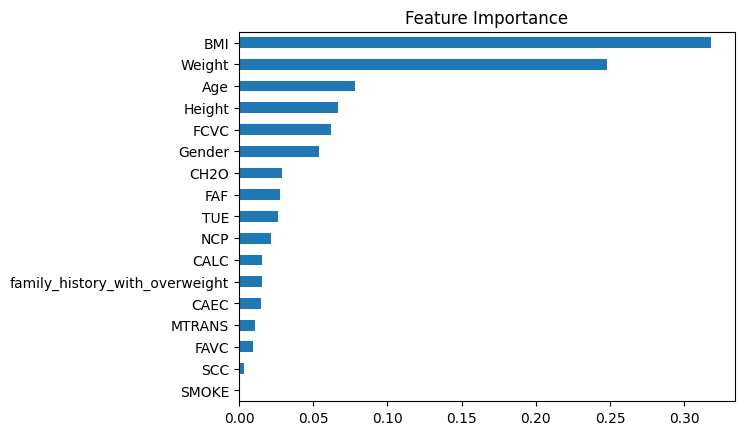

AFTER DROPPING SMOKE,SCC
0.8973988439306358
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       626
           1       0.97      0.97      0.97       657
           2       0.80      0.79      0.80       514
           3       0.94      0.93      0.93       524
           4       0.88      0.87      0.87       543
           5       1.00      1.00      1.00       804
           6       0.76      0.76      0.76       484

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



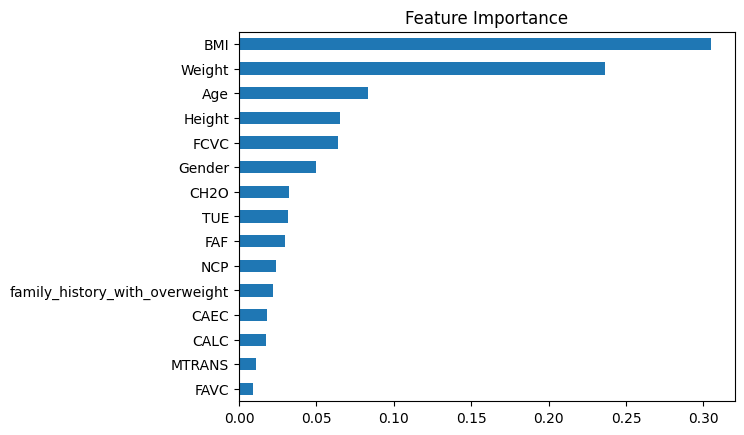

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
rf_model = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)




print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
importances = rf_model.feature_importances_


feat_importances = pd.Series(importances, index=X_train.columns)


feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()
print("AFTER DROPPING SMOKE,SCC")
X_train=X_train.drop(['SMOKE','SCC'],axis=1)
X_test=X_test.drop(['SMOKE','SCC'],axis=1)
rf_model.fit(X_train,y_train)
y_pred=rf_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)


feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       626
           1       0.98      0.97      0.97       657
           2       0.81      0.81      0.81       514
           3       0.95      0.93      0.94       524
           4       0.89      0.87      0.88       543
           5       0.99      1.00      1.00       804
           6       0.79      0.80      0.80       484

    accuracy                           0.91      4152
   macro avg       0.90      0.90      0.90      4152
weighted avg       0.91      0.91      0.91      4152

[[558   0   6  24   0   1  37]
 [  0 638   2   0  14   3   0]
 [  9   3 418   0  36   0  48]
 [ 32   0   1 488   0   0   3]
 [  1  11  40   2 473   1  15]
 [  0   1   0   0   0 802   1]
 [ 33   0  51   1  11   0 388]]
0.9067919075144508


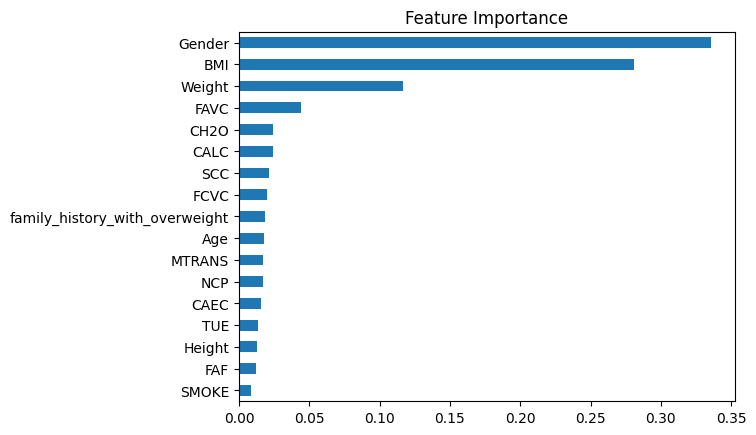

AFTER DROPPING SMOKE
0.9072736030828517
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       626
           1       0.98      0.97      0.98       657
           2       0.82      0.82      0.82       514
           3       0.95      0.92      0.94       524
           4       0.89      0.88      0.89       543
           5       0.99      1.00      1.00       804
           6       0.78      0.80      0.79       484

    accuracy                           0.91      4152
   macro avg       0.90      0.90      0.90      4152
weighted avg       0.91      0.91      0.91      4152



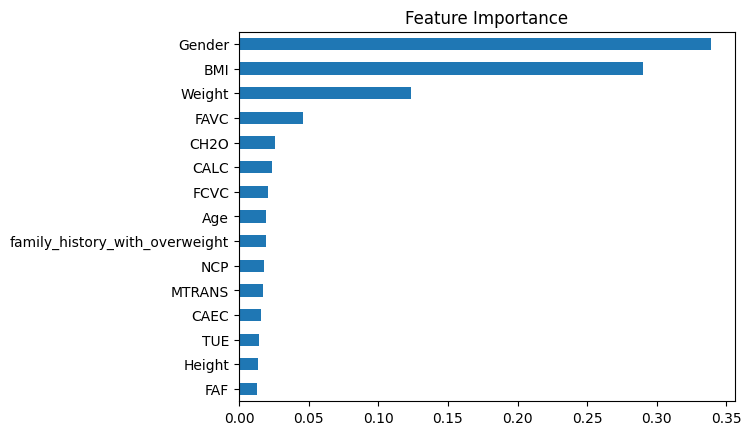

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
Xg_model=XGBClassifier()
Xg_model.fit(X_train,Y_train)
y_pred=Xg_model.predict(X_test)
print(classification_report(Y_test, y_pred))
cm = confusion_matrix(Y_test, y_pred)
print(cm)
print(accuracy_score(Y_test, y_pred))
importances = Xg_model.feature_importances_

feat_importances = pd.Series(importances, index=X_train.columns)

feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()
print("AFTER DROPPING SMOKE")
X_train=X_train.drop(['SMOKE','SCC'],axis=1)
X_test=X_test.drop(['SMOKE','SCC'],axis=1)
Xg_model.fit(X_train,Y_train)
y_pred=Xg_model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
importances = Xg_model.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)


feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 17
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       626
           1       0.97      0.97      0.97       657
           2       0.81      0.80      0.80       514
           3       0.94      0.93      0.93       52

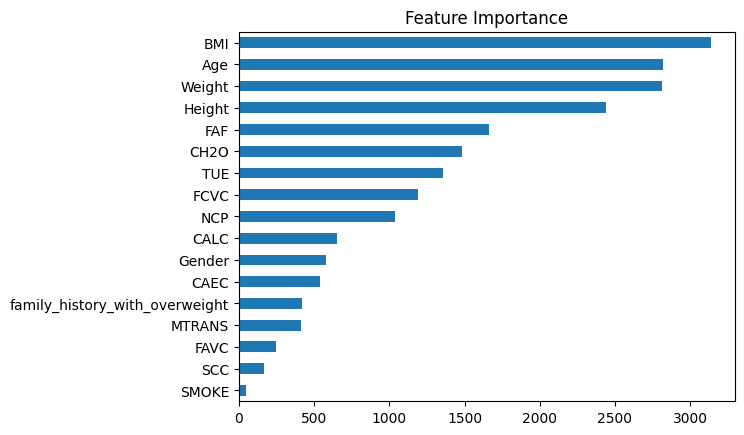

AFTER DROPPING SMOKE,SCC
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2270
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 15
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
0.9000481695568401
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       626
           1       0.97      0.97      0.97       657
           2       0.80      0.81      0.80       514
        

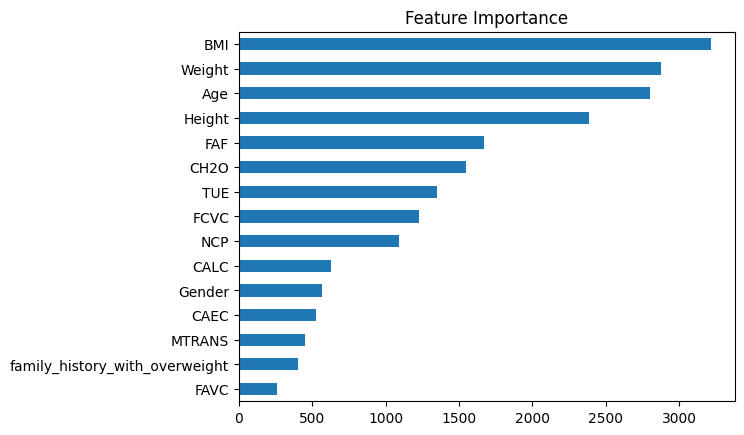

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(max_depth=20)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)




print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(Y_test, y_pred))
importances = model.feature_importances_

feat_importances = pd.Series(importances, index=X_train.columns)


feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()
print("AFTER DROPPING SMOKE,SCC")
X_train=X_train.drop(['SMOKE','SCC'],axis=1)
X_test=X_test.drop(['SMOKE','SCC'],axis=1)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)


feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [ ]:
X=X.drop(['SMOKE','SCC'],axis=1)

Basic Multinomial regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)


lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       617
           1       0.93      0.97      0.95       650
           2       0.71      0.67      0.69       504
           3       0.86      0.94      0.90       505
           4       0.81      0.82      0.81       582
           5       0.99      1.00      0.99       809
           6       0.71      0.68      0.70       485

    accuracy                           0.85      4152
   macro avg       0.84      0.84      0.84      4152
weighted avg       0.85      0.85      0.85      4152

=== Confusion Matrix ===
[[492   0   5  72   0   0  48]
 [  0 629   6   0  15   0   0]
 [  8   3 339   0  79   0  75]
 [ 30   0   0 475   0   0   0]
 [  0  46  46   0 475   6   9]
 [  0   1   0   1   0 806   1]
 [ 57   0  79   2  15   0 332]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
from sklearn.model_selection import GridSearchCV
rf_model = RandomForestClassifier(
    random_state=42,n_estimators=150,max_depth=15
)
#param_grid = {
    #'n_estimators': [50, 100, 150],
    #'max_depth': [5, 10, 15, None]
#}
#grid_search = GridSearchCV(
    #estimator=rf_model,
    #param_grid=param_grid,
    #cv=3,
    #scoring='f1_macro',


#)

# Fit on training data
#grid_search.fit(X_train, y_train)

# Best parameters and model
#print("Best Parameters:", grid_search.best_params_)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       617
           1       0.96      0.98      0.97       650
           2       0.80      0.80      0.80       504
           3       0.91      0.93      0.92       505
           4       0.88      0.86      0.87       582
           5       1.00      1.00      1.00       809
           6       0.81      0.77      0.79       485

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152

=== Confusion Matrix ===
[[544   0   5  42   0   0  26]
 [  0 638   3   0   9   0   0]
 [  7   0 402   0  51   0  44]
 [ 34   0   0 471   0   0   0]
 [  0  25  38   0 503   2  14]
 [  0   0   0   1   1 806   1]
 [ 47   0  52   2  10   0 374]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#param_grid = {
    #'n_estimators': [50, 100, 150],
    #'max_depth': [5, 10, 15, None],
    #'learning_rate': [0.01, 0.05, 0.1],
    #'num_leaves':[5,10,15,20]
#}
#grid_search = GridSearchCV(
    #estimator=rf_model,
    #param_grid=param_grid,
    #cv=3,
    #scoring='f1_macro',


#)

# Fit on training data
#grid_search.fit(X_train, y_train)

# Best parameters and model
#print("Best Parameters:", grid_search.best_params_)

lgbm=LGBMClassifier(learning_rate=0.1, max_depth=5,n_estimators=150,num_leaves=15,random_state=42)

lgbm.fit(X_train, y_train)


y_pred = lgbm.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 15
[LightGBM] [Info] Start training from score -1.907572
[LightGBM] [Info] Start training from score -1.855022
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -1.964755
[LightGBM] [Info] Start training from score -1.635117
[LightGBM] [Info] Start training from score -2.146046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    use_label_encoder=False,
    random_state=42
)

model_normal = LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=150,random_state=42)
#param_grid = {
    #'n_estimators': [50, 100, 150],
    #'learning_rate': [0.01, 0.05, 0.1],
    #'max_depth': [3, 5, 7, 10],
#}
#grid_search = GridSearchCV(
    #param_grid=param_grid,
    #cv=3,
   # scoring='f1_macro',


#)


#grid_search.fit(X_train, y_train)


#print("Best Parameters:", grid_search.best_params_)
xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, ))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:26:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9058285163776493

Confusion Matrix:
[[541   0   5  39   0   0  32]
 [  0 637   2   0  11   0   0]
 [  7   0 410   0  49   0  38]
 [ 34   0   0 471   0   0   0]
 [  1  24  28   0 515   1  13]
 [  0   0   0   1   1 806   1]
 [ 40   0  50   2  12   0 381]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       617
           1       0.96      0.98      0.97       650
           2       0.83      0.81      0.82       504
           3       0.92      0.93      0.93       505
           4       0.88      0.88      0.88       582
           5       1.00      1.00      1.00       809
           6       0.82      0.79      0.80       485

    accuracy                           0.91      4152
   macro avg       0.90      0.90      0.90      4152
weighted avg       0.91      0.91      0.91      4152



In [ ]:

from sklearn.ensemble import VotingClassifier


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)




ensemble = VotingClassifier(
    estimators=[
        ('lr',lr_model),
        ('rf',rf_model),
        ('xgb', xgb_model),
        ('lgbm_n',lgbm)
    ],
    voting='soft',
    weights=[0.2,1,1,1.5],  #  you can tune this


)


ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

print("Ensemble Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
int_to_label = {v: k for k, v in random_map.items()}
target_names = [int_to_label[i] for i in range(len(int_to_label))]

print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=target_names))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 15
[LightGBM] [Info] Start training from score -1.907572
[LightGBM] [Info] Start training from score -1.855022
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -1.964755
[LightGBM] [Info] Start training from score -1.635117
[LightGBM] [Info] Start training from score -2.146046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 